Import all the packages:

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import matplotlib as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

Read the data set:

In [11]:
data_frame = pd.read_csv("../main_datasets/sarcasm_data.csv")

In [12]:
data_frame.head()

,Unnamed: 0.1,Unnamed: 0,label,comment,votes,sentiment
0,0,0,0,NC and NH.,-1,0
1,1,1,0,You do know west teams play against west teams...,-1,1
2,2,2,0,"They were underdogs earlier today, but since G...",3,0
3,3,3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,4,4,0,I could use one of those tools.,-1,1


Drop the irrelevant columns:

In [13]:
data_frame = data_frame[["comment", "votes", "sentiment","label"]]
data_frame.head()

,comment,votes,sentiment,label
0,NC and NH.,-1,0,0
1,You do know west teams play against west teams...,-1,1,0
2,"They were underdogs earlier today, but since G...",3,0,0
3,"This meme isn't funny none of the ""new york ni...",-1,0,0
4,I could use one of those tools.,-1,1,0


Transform the textual data:

In [14]:
vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(data_frame['comment'])
X_train_text

<1010773x167435 sparse matrix of type '<class 'numpy.float64'>'
	with 9548157 stored elements in Compressed Sparse Row format>

Combine the matrix with the other continous features:

In [15]:
X = hstack((X_train_text, data_frame[['sentiment', 'votes']].values))
X

<1010773x167437 sparse matrix of type '<class 'numpy.float64'>'
	with 11120125 stored elements in COOrdinate format>

In [17]:
y = data_frame["label"]
y.shape

(1010773,)

Split the data into training and test data:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Train a new instance of DecisionTreeClassifier:

In [19]:
model = DecisionTreeClassifier()
model

DecisionTreeClassifier()

In [20]:
model = model.fit(X_train, y_train)
model

DecisionTreeClassifier()

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.65      0.64    202020
           1       0.63      0.61      0.62    202290

    accuracy                           0.63    404310
   macro avg       0.63      0.63      0.63    404310
weighted avg       0.63      0.63      0.63    404310



Plot the confusion matrix:

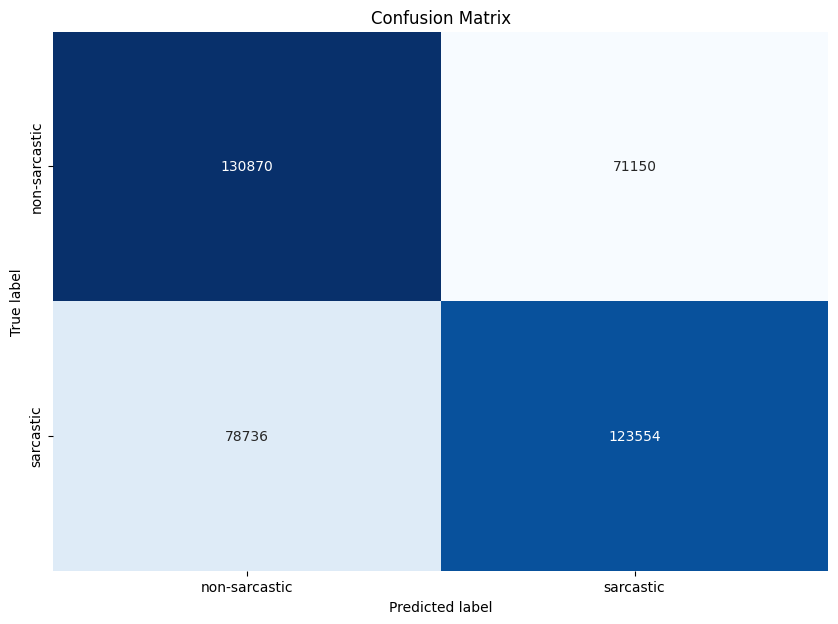

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=cm, cmap='Blues', fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    # Set the axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Set the title
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()
plot_confusion_matrix(y_test, y_pred, ["non-sarcastic", "sarcastic"])

Plot the ROC-auc curve:

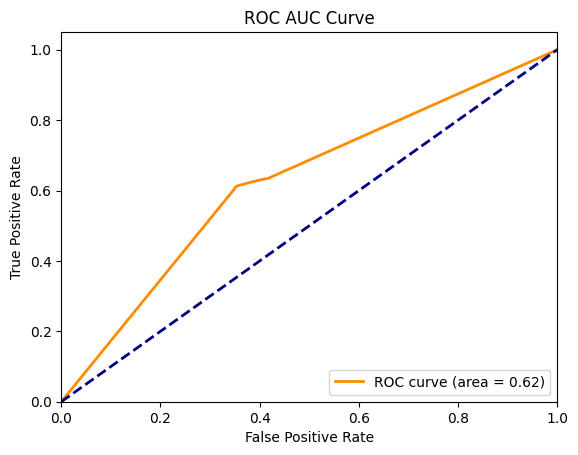

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test)
def plot_roc_auc_curve(y_true, y_pred_proba, title='ROC AUC Curve'):
    # Compute the ROC curve points and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Create the ROC curve plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

plot_roc_auc_curve(y_test, y_pred_proba[:,1])


In [28]:
import numpy as np
from sklearn.metrics import roc_curve

def find_best_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate the Youden's J statistic for each threshold
    j_scores = tpr - fpr
    
    # Find the index of the best threshold
    best_threshold_index = np.argmax(j_scores)
    
    # Return the best threshold
    return thresholds[best_threshold_index]

threshold = find_best_threshold(y_test, y_pred_proba[:,1])
threshold

0.5625

In [31]:
def make_predictions(y_proba) -> int:
    predictions = list()
    for value in y_proba[:,1]:
        if value >= 0.3:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

              precision    recall  f1-score   support

           0       0.62      0.64      0.63    202020
           1       0.63      0.61      0.62    202290

    accuracy                           0.63    404310
   macro avg       0.63      0.63      0.63    404310
weighted avg       0.63      0.63      0.63    404310



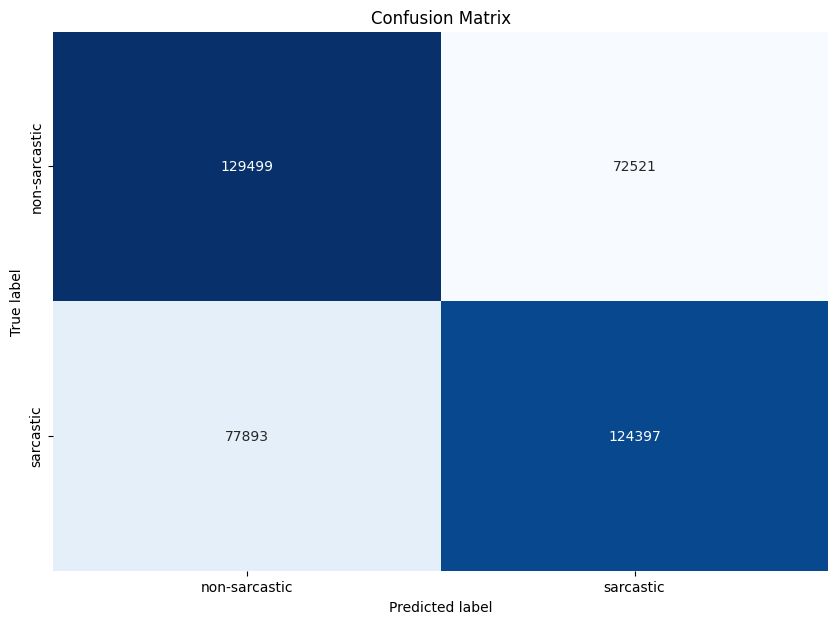

In [33]:
print(classification_report(y_test, make_predictions(y_pred_proba)))
plot_confusion_matrix(y_test, make_predictions(y_pred_proba), ["non-sarcastic", "sarcastic"])

In [34]:
from joblib import dump

dump(model, "decision_tree.joblib")

['decision_tree.joblib']